# ECSE 415 Final Project: Section 6 (Bonus)

This notebook contains our implementation of a fine-tuned U-Net++ for multiclass segmentation.

In [84]:
from stardist.models import StarDist2D
from stardist.data import test_image_he_2d
from csbdeep.utils import normalize
from cellpose import models, io

import tensorflow as tf
import torch
import torch.nn as nn
import torchvision

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv

import os
import shutil
import re
import csv
from tqdm import tqdm

from utils import dice_coefficient
from sklearn.metrics import accuracy_score

torch.manual_seed(0)
np.random.seed(0)

# 6.1. Helper functions

In [6]:
def get_image_mask_pairs(subjects, rgb_path, mask_path):
    '''
    Match images with labels in the csv file.
    '''
    images = []
    masks = []
    for patient in subjects:
        for file in os.listdir(rgb_path):
            if re.match(patient[0], file):
                images.append(os.path.join(rgb_path, file))
                masks.append(os.path.join(mask_path, file))
    return images, masks

def load_image(path, target_shape=(256,256)):
    '''
    Load a single image for fine-tuning.
    '''
    if path.endswith('.png'):
        img = cv.imread(path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, target_shape)
        # img = normalize(img)
        return img
    else:
        print("Path invalid:", path)

def load_mask(path, target_shape=(256,256)):
    '''
    Load a single mask for fine-tuning.
    '''
    if path.endswith('.png'):
        mask = cv.imread(path)[:,:,0]
        mask = cv.resize(mask, target_shape)
        # mask = mask > 2
        return mask
    else:
        print("Path invalid:", path)

def load_imask(path, target_shape=(256,256)):
    '''
    Load a single instance mask for fine-tuning.
    '''
    if path.endswith('.png'):
        mask = cv.imread(path)
        imask = mask[:, :, 1] * mask[:, :, 2]
        imask = cv.resize(imask, target_shape, interpolation=cv.INTER_NEAREST)
        return imask
    else:
        print("Path invalid:", path)

def ce_encode_imask(imask, valid_classes, reject_classes):
    '''
    Encode instance masks to do multi-class segmentation with CrossEntropyLoss.
    '''
    _imask = np.copy(imask)
    for i, c in enumerate(sorted(valid_classes)):
        _imask[_imask==c] = i+1
    
    for c in sorted(reject_classes):
        _imask[_imask==c] = 0
        
    return _imask

def process_img(img, preprocessing_fn, dtype=torch.float32):
    '''
    Process image before input into segmentation model.
    '''
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img = preprocessing_fn(img)
    img = np.moveaxis(img, 2, 0)
    img = np.expand_dims(img, 0)
    img = torch.from_numpy(img)
    return img.to(dtype)

def process_imask(imask, dtype=torch.float32):
    '''
    Process image before input into segmentation model.
    '''
    imask = np.expand_dims(imask, 0)
    imask = torch.from_numpy(imask).to(dtype)
    return imask.to(dtype)

# 6.2. Set device, load paths, and load data

In [85]:
DEVICE = 'cuda:0'

In [8]:
root = '.'
path = os.path.join(root, 'QC')
train_test_path = os.path.join(path, 'split')
mask_path = os.path.join(path, "mask")
rgb_path = os.path.join(path, "rgb")
csv_path = os.path.join(path, "csv")

# Load training and validation csv files
def load_subjects(csv_path):
    with open(csv_path, newline='') as f:
        reader = csv.reader(f)
        subjects = list(reader)
    return subjects[1:]

train_subjects = load_subjects(os.path.join(train_test_path, 'train_subjects.csv'))
train_images, train_masks = get_image_mask_pairs(train_subjects, rgb_path, mask_path)

# 6.3. Load finetuning data

In [9]:
DISPLAY_MASKS = False
SUBJECT = 'TCGA-EW-A1P1-DX1'

subject_images = []
subject_masks = []
for ipath, mpath in zip(train_images, train_masks):
    if ipath.split('/')[-1].startswith(SUBJECT):
        subject_images.append(ipath)
        subject_masks.append(mpath)
        

n_train = 30

X = []
_Y = []

classes = set()
for ipath, mpath in zip(subject_images, subject_masks):

    img = load_image(ipath)
    imask = load_imask(mpath)
    
    X.append(img)
    _Y.append(imask)

    unique = np.unique(imask)
    classes.update(set(list(unique)))

    if DISPLAY_MASKS:
        for u in unique:
            if not(u in classes):
                fig, ax = plt.subplots()
                ax.set_title(u)
                ax.imshow(imask == u)

# 6.4. Determine class frequency and define train/test split

Technically, class frequency should be determined over the training set only.<br>
However, we realized this too late, and could not re-run our models before submission.

In [ ]:
CLASS_FREQUENCY = dict()
REJECT_CLASSES = {0, 253}
VALID_CLASSES = classes.difference(REJECT_CLASSES)

unique = set()
Y = []
for imask in _Y:
    
    imask = ce_encode_imask(imask, VALID_CLASSES, REJECT_CLASSES)
    for val in list(imask.flatten()):
        unique.add(val)
        
        if not(val in CLASS_FREQUENCY.keys()):
            CLASS_FREQUENCY[val] = 1
        else:
            CLASS_FREQUENCY[val] += 1

    Y.append(imask)

X_train = X[0:n_train]
Y_train = Y[0:n_train]

X_test  = X[n_train:]
Y_test  = Y[n_train:]

print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 30
Test set size: 8


Text(0, 0.5, 'Weight')

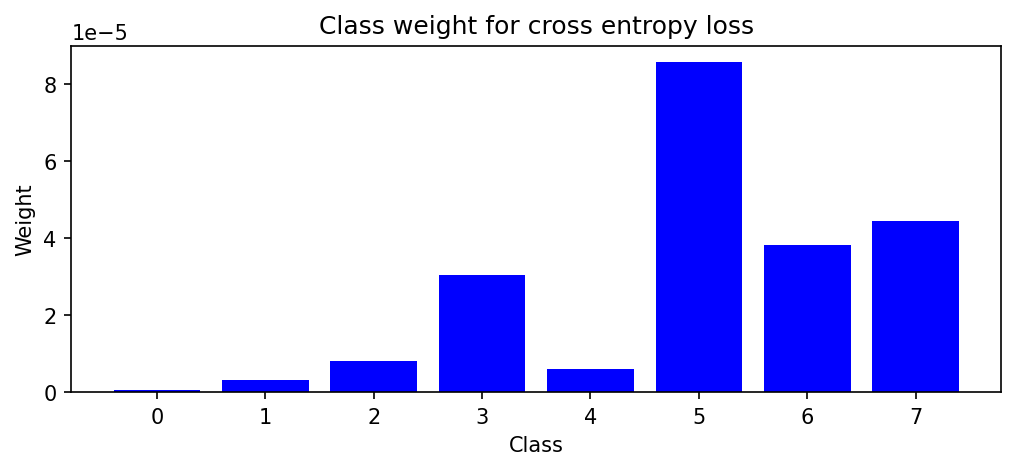

In [11]:
CLASS_WEIGHT = torch.tensor([1/f for f in CLASS_FREQUENCY.values()]).to(DEVICE)

# CLASS_WEIGHT[-1] *= 3

fig, ax = plt.subplots(figsize=(8, 3))
fig.dpi = 150
ax.set_title("Class weight for cross entropy loss")
ax.bar(np.arange(len(CLASS_WEIGHT)), CLASS_WEIGHT.detach().cpu().numpy(), color='blue')
ax.set_xlabel("Class")
ax.set_ylabel("Weight")

# 6.5. Define model and other training objects

In [12]:
class Model(nn.Module):
    def __init__(self, model, freeze=False):
        super().__init__()
        self.model = model
        if freeze:
            self.freeze()
    
    def freeze(self):
        for name, param in self.model.named_parameters():
            if ("decoder" in name) or ("segmentation" in name):
                param.requires_grad = True
            else:
                param.requires_grad = False

    def forward(self, x):
        return self.model(x)

In [19]:
class HP:
    epochs: int = 30
    learning_rate: float = 1e-4
    
def train_setup(encoder_weights="imagenet", freeze=False):
    _model = smp.UnetPlusPlus(
        encoder_name="resnet34",
        encoder_weights=encoder_weights,
        encoder_depth=5,
        decoder_channels=(256, 128, 64, 32, 16),
        decoder_attention_type='scse',
        in_channels=3,
        classes=len(VALID_CLASSES)+1
    )

    model = Model(_model, freeze=freeze).to(DEVICE)
    optimizer = torch.optim.Adam(model.named_parameters(), lr=HP.learning_rate)
    loss_fn = nn.CrossEntropyLoss(weight=CLASS_WEIGHT)
    preprocessing_fn = get_preprocessing_fn("resnet34", pretrained="imagenet")

    return model, optimizer, loss_fn, preprocessing_fn

In [14]:
def train(X_train, Y_train, model, optimizer, loss_fn, preprocessing_fn):
    model.train()
    train_loss = 0
    for _img, _imask in zip(X_train, Y_train):

        optimizer.zero_grad()

        img = process_img(_img, preprocessing_fn).to(DEVICE)
        imask = process_imask(_imask, dtype=torch.long).to(DEVICE)

        out = model(img)
        loss = loss_fn(out, imask)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss

def test(X_test, Y_test, model, loss_fn, preprocessing_fn):
    model.eval()
    test_loss = 0
    for _img, _imask in zip(X_test, Y_test):
        with torch.no_grad():
            img = process_img(_img, preprocessing_fn).to(DEVICE)
            imask = process_imask(_imask, dtype=torch.long).to(DEVICE)

            out = model(img)

            loss = loss_fn(out, imask)

            test_loss += loss.item()

    return test_loss

# 6.7. Train model

To reproduce the results described in our report:
- FINETUNED: Set encoder_weights="imagenet" and set freeze=False
- FROZEN: Set encoder_weights="imagenet" and set freeze=True
- SCRATCH: Set encoder_weights=None and set freeze=False

In [ ]:
num_experiments = 5
experiments = {i:dict(model=None, train_loss=[], test_loss=[]) for i in range(num_experiments)}

for exp in experiments.keys():
    model, optimizer, loss_fn, preprocessing_fn = train_setup(encoder_weights=None, freeze=False)

    pbar = tqdm(range(HP.epochs))
    for epoch in pbar:

        train_loss = train(X_train, Y_train, model, optimizer, loss_fn, preprocessing_fn)
        experiments[exp]['train_loss'].append(train_loss)
        pbar.set_description(f"Train epoch loss: {train_loss}")

        test_loss = test(X_train, Y_train, model, loss_fn, preprocessing_fn)
        experiments[exp]['test_loss'].append(test_loss)

    experiments[exp]['model'] = model

Train epoch loss: 4.864995442330837: 100%|██████████| 30/30 [01:08<00:00,  2.29s/it] 


# 6.8. Evaluate post-training

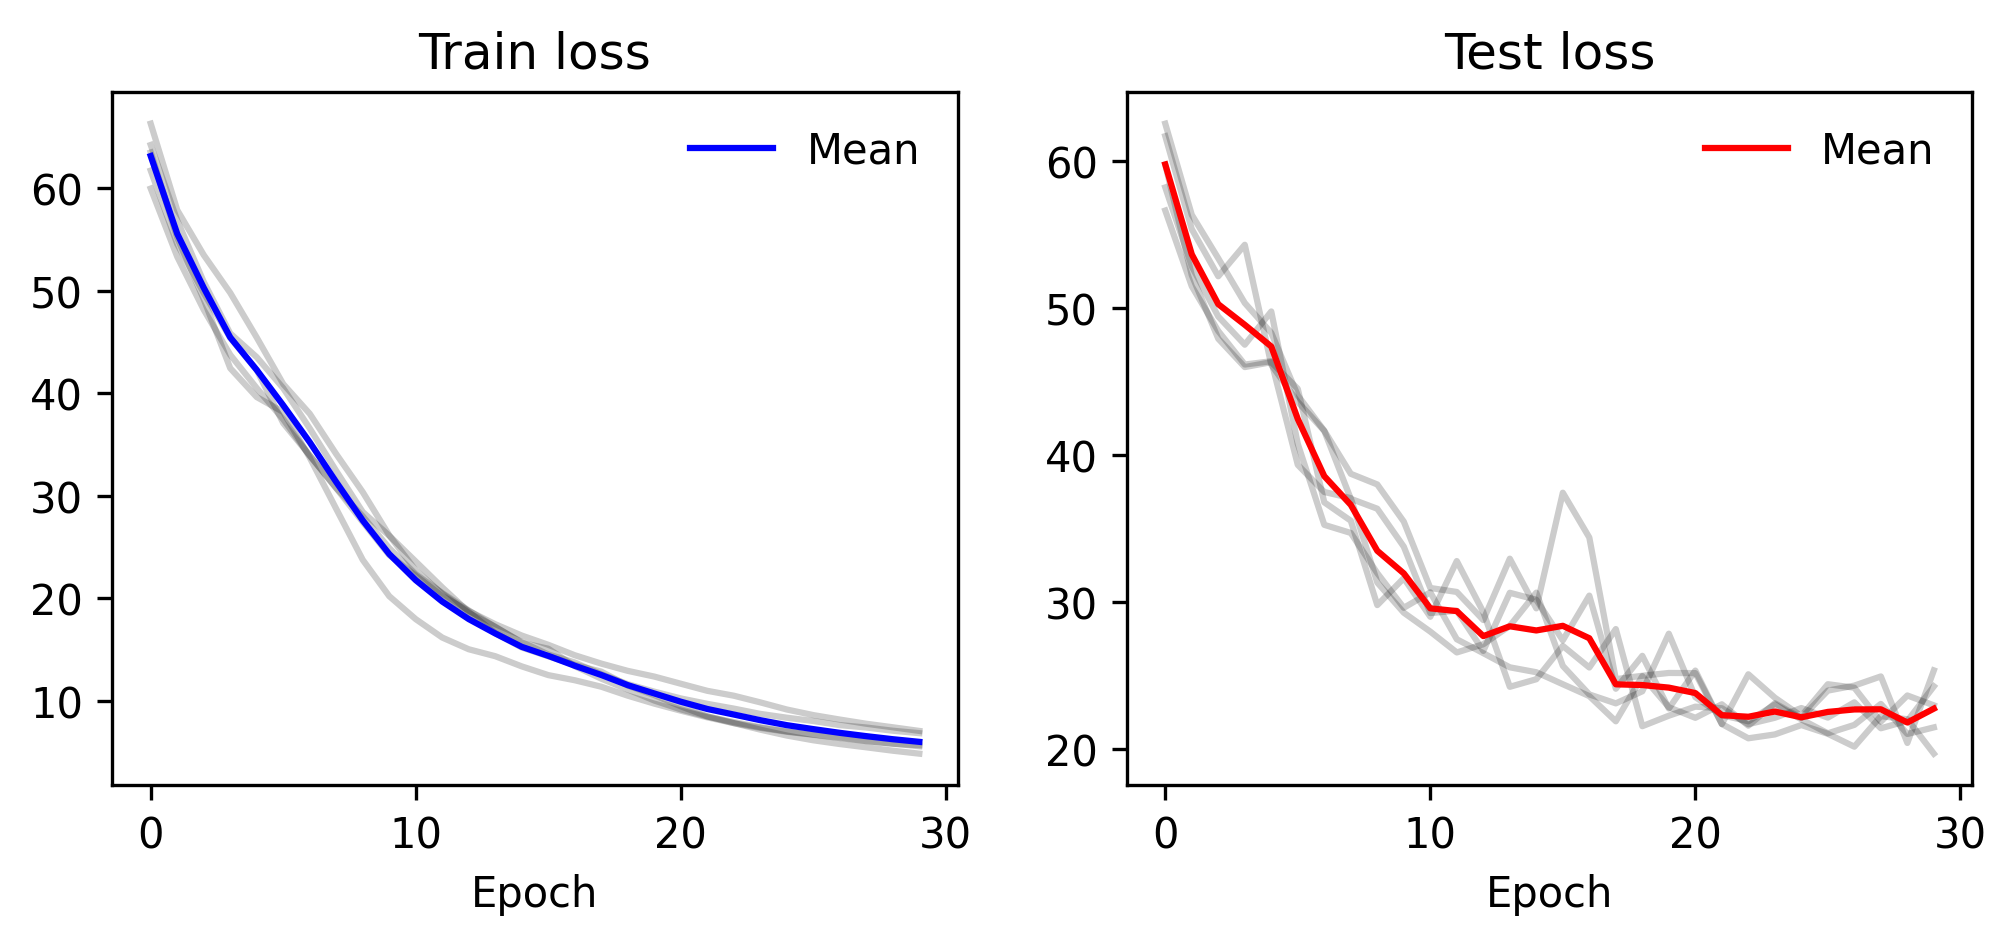

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
fig.dpi = 300

mean_train_loss = np.mean([experiments[exp]["train_loss"] for exp in experiments.keys()], axis=0)
mean_test_loss = np.mean([experiments[exp]["test_loss"] for exp in experiments.keys()], axis=0)

for exp in experiments.keys():
    ax[0].set_title("Train loss")
    ax[0].plot(experiments[exp]["train_loss"], color='black', alpha=0.2)
    ax[0].set_xlabel("Epoch")
    
    ax[1].set_title("Test loss")
    ax[1].plot(experiments[exp]["test_loss"], color='black', alpha=0.2)
    ax[1].set_xlabel("Epoch")

ax[0].plot(mean_train_loss, color='blue', label="Mean")
ax[1].plot(mean_test_loss, color='red', label="Mean")

ax[0].legend(frameon=False)
ax[1].legend(frameon=False)

In [42]:
def multiclass_dice_coefficient(y_true, y_pred, classes):
    dice = {c:None for c in classes if c in y_true}
    for c in dice.keys():
        _y_true = (y_true == c).astype(int)
        _y_pred = (y_pred == c).astype(int)
        dice[c] = dice_coefficient(_y_true, _y_pred)    
    return dice

### Visualize a training segmentation

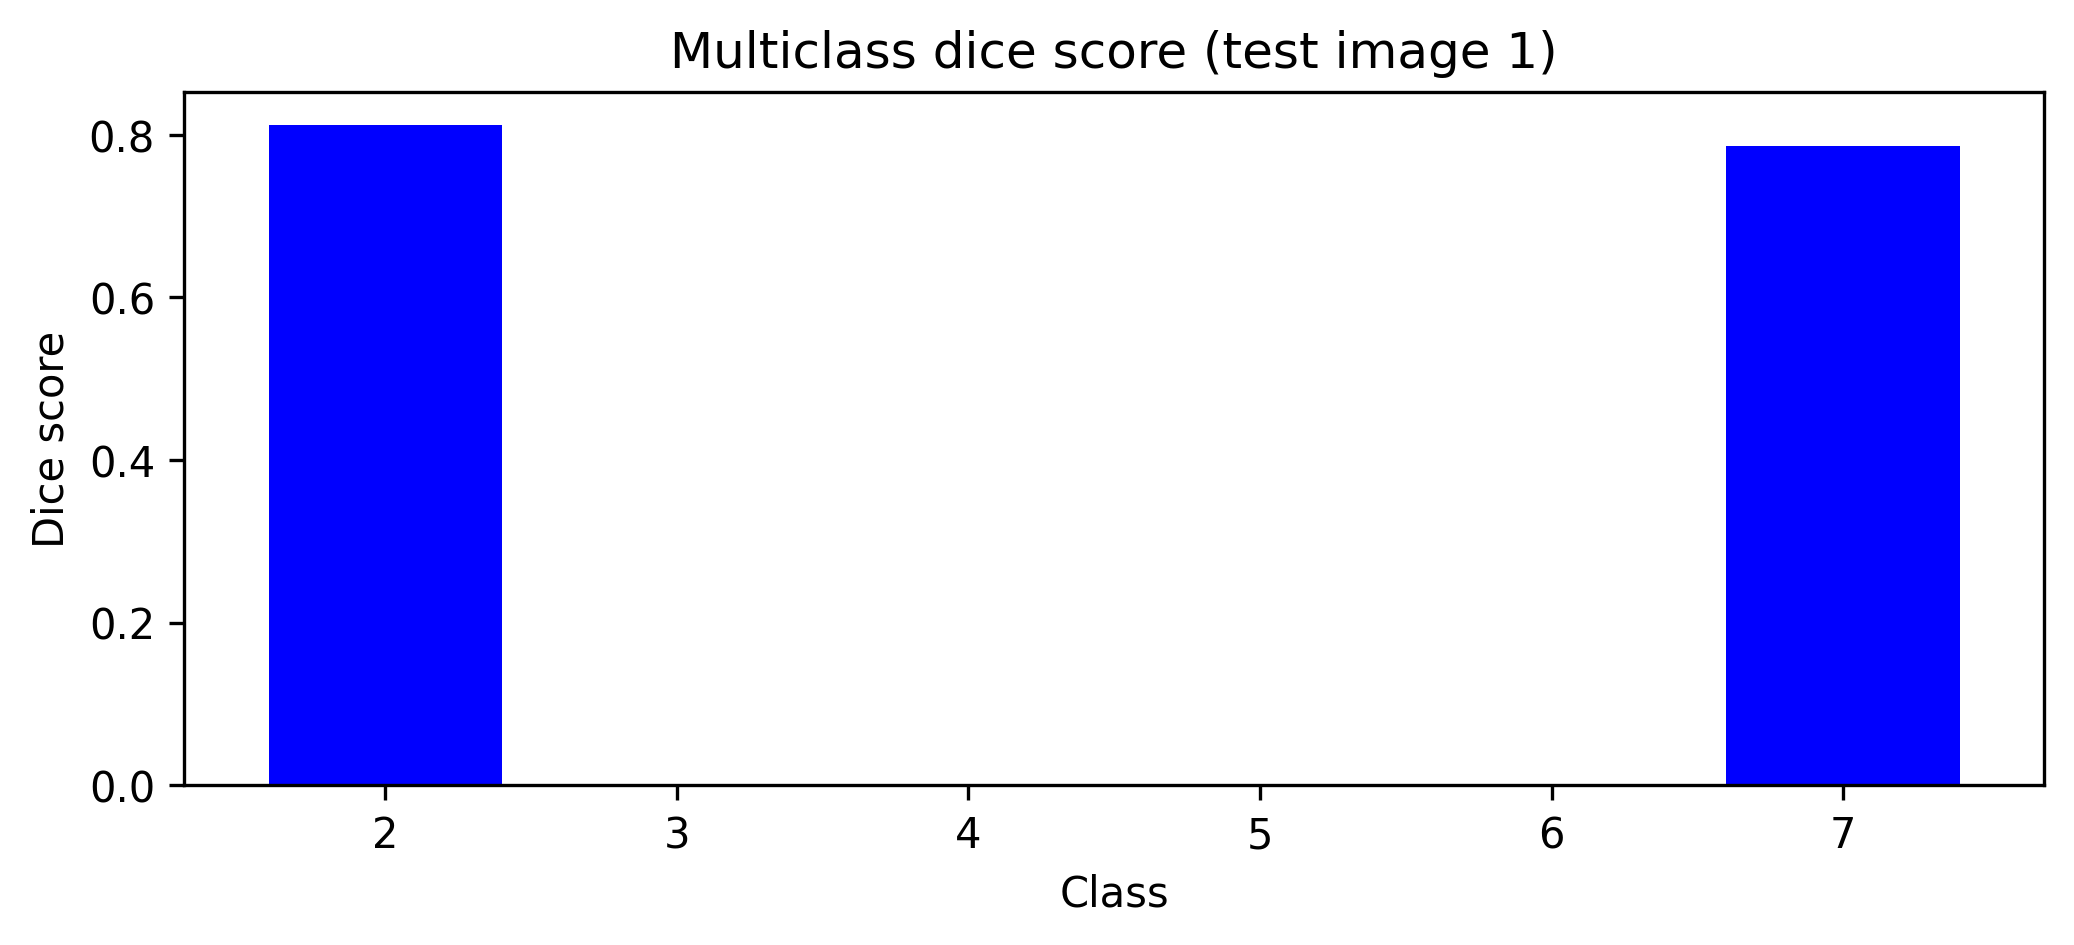

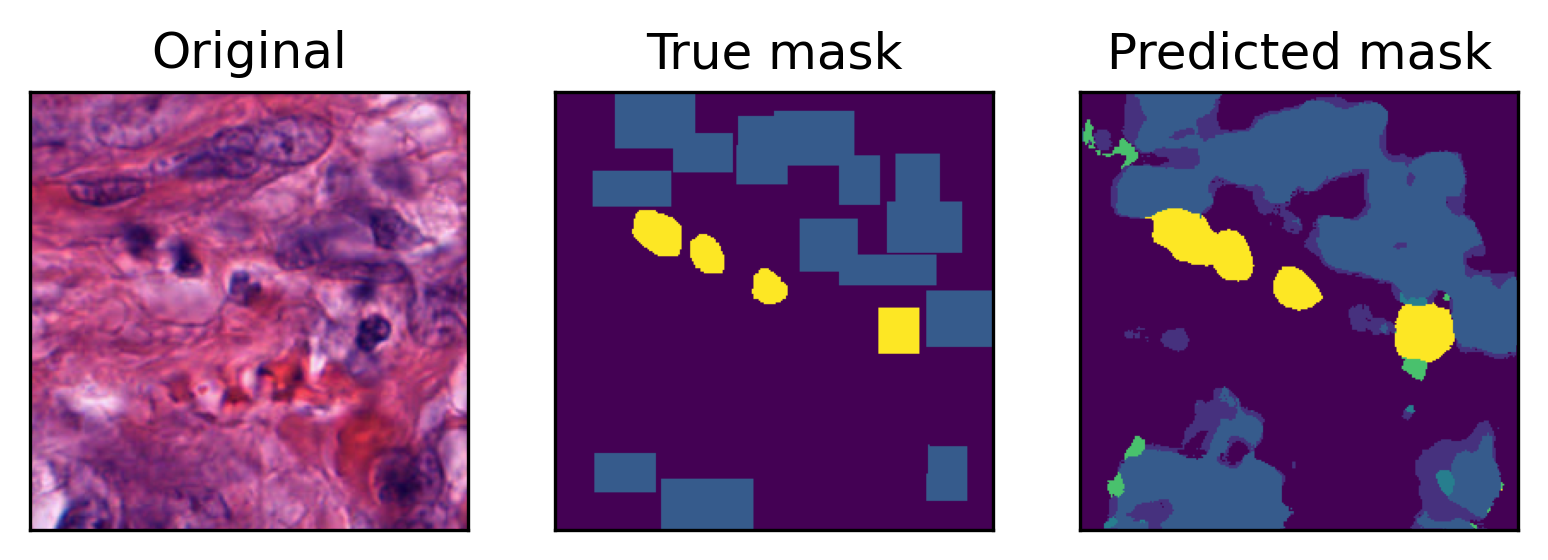

In [78]:
model = experiments[0]['model']

i = 1
x = X_train[i]
y = Y_train[i]
x = process_img(x, preprocessing_fn).to(DEVICE)

model.eval()
out = model(x)
pred = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
dice = multiclass_dice_coefficient(y, pred, np.arange(1, len(VALID_CLASSES)+1))

fig, ax = plt.subplots(figsize=(8, 3))
fig.dpi = 300
ax.bar(dice.keys(), dice.values(), color='blue')
ax.set_title(f"Multiclass dice score (test image {i})")
ax.set_xlabel("Class")
ax.set_ylabel("Dice score")

fig, ax = plt.subplots(1, 3) 
fig.dpi = 300
ax[0].imshow(((x-torch.min(x))/(torch.max(x)-torch.min(x))).squeeze().permute(1, 2, 0).detach().cpu().numpy())
ax[1].imshow(y, cmap='viridis')
ax[2].imshow(pred, cmap='viridis')

ax[0].set_title("Original")
ax[1].set_title("True mask")
ax[2].set_title("Predicted mask")

for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

### Visualize a testing segmentation

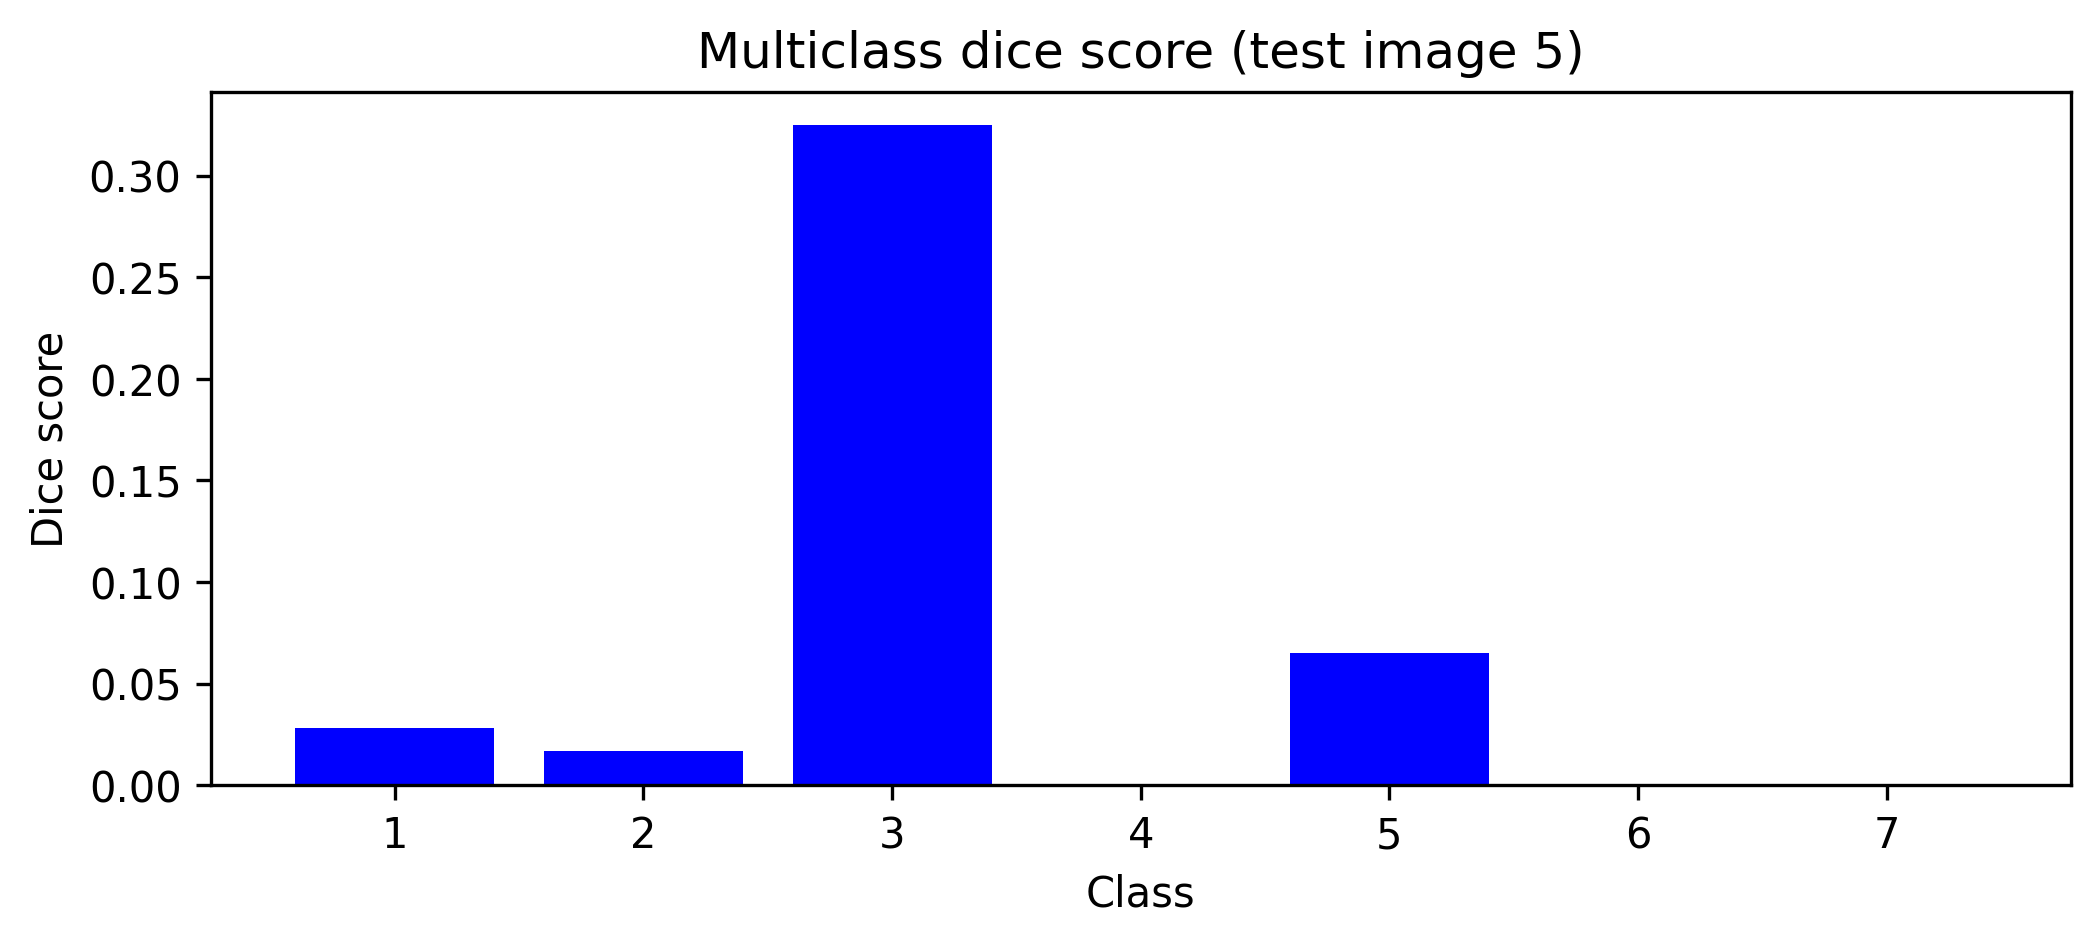

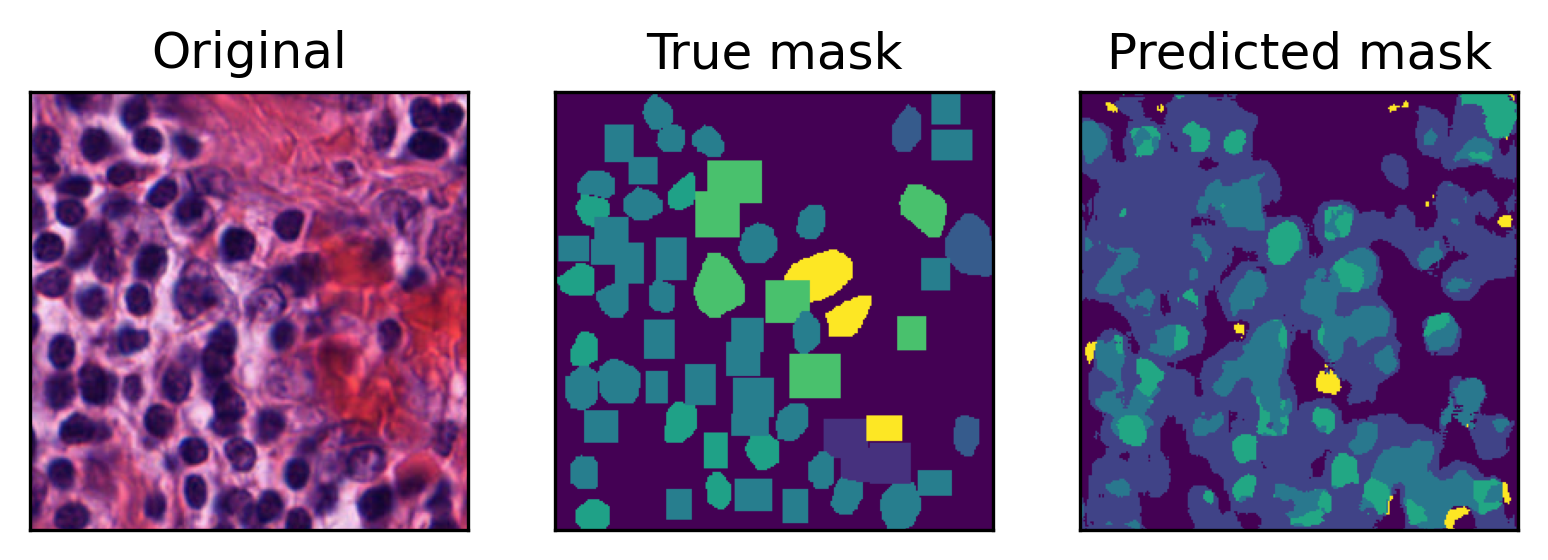

In [79]:
model = experiments[0]['model']

i = 5
x = X_test[i]
y = Y_test[i]
x = process_img(x, preprocessing_fn).to(DEVICE)

model.eval()
out = model(x)
pred = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
dice = multiclass_dice_coefficient(y, pred, np.arange(1, len(VALID_CLASSES)+1))

fig, ax = plt.subplots(figsize=(8, 3))
fig.dpi = 300
ax.bar(dice.keys(), dice.values(), color='blue')
ax.set_title(f"Multiclass dice score (test image {i})")
ax.set_xlabel("Class")
ax.set_ylabel("Dice score")

fig, ax = plt.subplots(1, 3) 
fig.dpi = 300
ax[0].imshow(((x-torch.min(x))/(torch.max(x)-torch.min(x))).squeeze().permute(1, 2, 0).detach().cpu().numpy())
ax[1].imshow(y, cmap='viridis')
ax[2].imshow(pred, cmap='viridis')

ax[0].set_title("Original")
ax[1].set_title("True mask")
ax[2].set_title("Predicted mask")

for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

### Compute average dice score over the training set

In [80]:
models = [experiments[exp]['model'] for exp in experiments.keys()]

_mean_dice = {k:0 for k in range(1, len(VALID_CLASSES)+1)}

for model in models:

    model_mean_dice = {i:0 for i in range(1, len(VALID_CLASSES)+1)}
    model_class_freq = {i:0 for i in range(1, len(VALID_CLASSES)+1)}

    for i,x,y in zip(range(len(X_train)), X_train, Y_train):
        x = process_img(x, preprocessing_fn).to(DEVICE)

        model.eval()
        out = model(x)
        pred = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
        dice = multiclass_dice_coefficient(y, pred, np.arange(1, len(VALID_CLASSES)+1))
        
        for k in dice.keys():
            model_mean_dice[k] += dice[k]
            model_class_freq[k] += 1

    model_mean_dice = {k:model_mean_dice[k] / model_class_freq[k] for k in model_mean_dice.keys()}

    for k, v in model_mean_dice.items():
        _mean_dice[k] += v

mean_dice = {k:_mean_dice[k] / len(experiments) for k in _mean_dice.keys()}

In [81]:
mean_dice

{1: 0.49957814896203667,
 2: 0.6977043644585154,
 3: 0.7108082489368092,
 4: 0.0,
 5: 0.5806629880543803,
 6: 0.6401042154125423,
 7: 0.5210444686086632}

### Compute average dice score over the testing set

In [82]:
models = [experiments[exp]['model'] for exp in experiments.keys()]

_mean_dice = {k:0 for k in range(1, len(VALID_CLASSES)+1)}

for model in models:

    model_mean_dice = {i:0 for i in range(1, len(VALID_CLASSES)+1)}
    model_class_freq = {i:0 for i in range(1, len(VALID_CLASSES)+1)}

    for i,x,y in zip(range(len(X_test)), X_test, Y_test):
        x = process_img(x, preprocessing_fn).to(DEVICE)

        model.eval()
        out = model(x)
        pred = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
        dice = multiclass_dice_coefficient(y, pred, np.arange(1, len(VALID_CLASSES)+1))
        
        for k in dice.keys():
            model_mean_dice[k] += dice[k]
            model_class_freq[k] += 1

    model_mean_dice = {k:model_mean_dice[k] / model_class_freq[k] for k in model_mean_dice.keys()}

    for k, v in model_mean_dice.items():
        _mean_dice[k] += v

mean_dice = {k:_mean_dice[k] / len(experiments) for k in _mean_dice.keys()}

In [83]:
mean_dice

{1: 0.1410923009587564,
 2: 0.3681617637697937,
 3: 0.31057586632791195,
 4: 0.0,
 5: 0.009465876889625474,
 6: 0.02649197243762099,
 7: 0.015901227629542082}